## Importing MNIST Dataset

In [21]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)   

### Verifiying Dataset Was Loaded Correctly via MnistDataloader class

In [33]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'MNIST'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte') #60,000 training images
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte') #10,000 test images
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

print(training_images_filepath)
print(training_labels_filepath)
print(test_images_filepath)
print(test_labels_filepath)

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray) # values go from 0 (black) to 256
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


MNIST\train-images-idx3-ubyte/train-images-idx3-ubyte
MNIST\train-labels-idx1-ubyte/train-labels-idx1-ubyte
MNIST\t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
MNIST\t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte


### Showing Some of the Images Based on Selected File Path

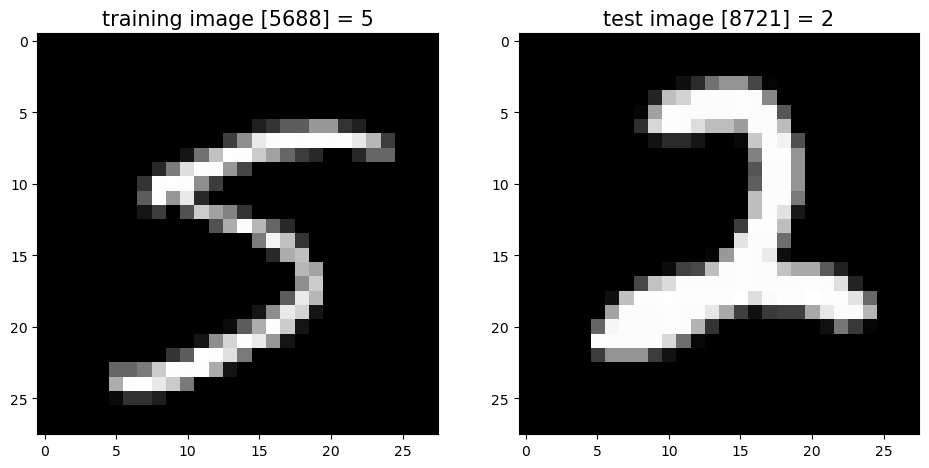

In [34]:
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 1): # how many random training images you want to show
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 1): # how many random test images you want to show
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Creating Neural Network (2 layers excluding the inputs)

There will be 2 layers. The inputs will be 28 * 28 neurons or 784 in total, the hidden layer will have 300 neurons, and then the output will have 10 neurons representing the likihood of each digit in this classification problem after applying the softmax function to the logit function.

In [136]:
# Defining parameters in neural network

neurons_input, neurons_l1, neurons_output = 784, 300, 10
randomGen = np.random.default_rng(seed=42)

W2 = randomGen.random((neurons_output, neurons_l1)) # for integers could use randomGen.integers(2,size=(10, 1))
b2 = randomGen.random((neurons_output, 1))
W1 = randomGen.random((neurons_l1, neurons_input)) #300 rows, 784 columns
b1 = randomGen.random((neurons_l1, 1))
p = [W1, b1, W2, b2] #parameters we need to periodically update using SGD and backprop.

#Construcing input and mini-batch
def GetMiniBatch(x_train): 
    numInputs = 100
    miniBatch = np.zeros((784,numInputs))
    for i in range(numInputs):
        r = random.randint(1, 60000) #we may sample the same images again from another batch
        temp = np.array(x_train[r])
        temp = np.reshape(temp, 784)
        miniBatch[:,i] = temp
    return miniBatch #each column represents a sample

GetMiniBatch(x_train).shape

(784, 100)

In [ ]:
#Foward Propagation
def sigmoid(z):
    return (1/(1 + np.exp(-z))
            
def sigmoidDeriv(z):
    return (1 - sigmoid(z))

def ForwardProp(miniBatch, W1, b1, W2, b2):
    #First Layer
    z1 = np.matmul(W1, miniBatch) + b1 # (300 X 784) X (784 X 100) + (300 X 1)
    a1 = sigmoid(z)
    #Second layer
    z2 = np.matmul(W2, a1) + b2 # (300 X 784) X (784 X 100) + (300 X 1)
    #Softmax
    np.dhd
    
            